In [ ]:
import torch
import os
import math

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b1, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

from PIL import Image


class Img2Vec:

    def __init__(self, model_name, weights="DEFAULT"):
        self.embed_dict = {
            "resnet50": self.obtain_children,
            "vgg19": self.obtain_classifier,
            "efficientnet_b1": self.obtain_classifier,
        }

        self.architecture = self.validate_model(model_name)
        self.weights = weights
        self.transform = self.assign_transform(weights)
        self.device = self.set_device()
        self.model = self.initiate_model()
        self.embed = self.assign_layer()
        self.dataset = {}
        self.image_clusters = {}
        self.cluster_centers = {}

    def validate_model(self, model_name):
        if model_name not in self.embed_dict.keys():
            raise ValueError(f"The model {model_name} is not supported")
        else:
            return model_name

    def assign_transform(self, weights):
        weights_dict = {
            "resnet50": models.ResNet50_Weights,
            "vgg19": models.VGG19_Weights,
            "efficientnet_b1": models.efficientnet_b1(pretrained=True)
        }
        try:
            w = weights_dict[self.architecture]
            weights = getattr(w, weights)
            preprocess = weights.transforms()
        except Exception:
            preprocess = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            )

        return preprocess

    def set_device(self):
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
        return device

    def initiate_model(self):
        m = getattr(
            models, self.architecture
        )
        model = m(weights=self.weights)
        model.to(self.device)
        return model.eval()

    def assign_layer(self):
        model_embed = self.embed_dict[self.architecture]()
        return model_embed

    def obtain_children(self):
        model_embed = nn.Sequential(*list(self.model.children())[:-1])
        return model_embed

    def obtain_classifier(self):
        self.model.classifier = self.model.classifier[:-1]
        return self.model

    def directory_to_list(self, dir):
        ext = (".png", ".jpg", ".jpeg")

        d = os.listdir(dir)
        source_list = [os.path.join(dir, f) for f in d if os.path.splitext(f)[1] in ext]

        return source_list

    def validate_source(self, source):
        if isinstance(source, list):
            source_list = [f for f in source if os.path.isfile(f)]
        elif os.path.isdir(source):
            source_list = self.directory_to_list(source)
        elif os.path.isfile(source):
            source_list = [source]
        else:
            raise ValueError('"source" expected as file, list or directory.')

        return source_list

    def embed_image(self, img):
        img = Image.open(img)
        img_trans = self.transform(img)

        if self.device == "cuda:0":
            img_trans = img_trans.cuda()

        img_trans = img_trans.unsqueeze(0)

        return self.embed(img_trans)

    def embed_dataset(self, source):
        self.files = self.validate_source(source)

        for file in self.files:
            vector = self.embed_image(file)
            self.dataset[str(file)] = vector

        return

    def similar_images(self, target_file, n=None):

        target_vector = self.embed_image(target_file)

        cosine = nn.CosineSimilarity(dim=1)

        sim_dict = {}
        for k, v in self.dataset.items():
            sim = cosine(v, target_vector)[0].item()
            sim_dict[k] = sim

        items = sim_dict.items()
        sim_dict = {k: v for k, v in sorted(items, key=lambda i: i[1], reverse=True)}

        if n is not None:
            sim_dict = dict(list(sim_dict.items())[: int(n)])

        self.output_images(sim_dict, target_file)

        return sim_dict

    def output_images(self, similar, target):
        self.display_img(target, "original")

        for k, v in similar.items():
            self.display_img(k, "similarity:" + str(v))

        return

    def display_img(self, path, title):
        plt.imshow(Image.open(path))
        plt.axis("off")
        plt.title(title)
        plt.show()

        return

    def save_dataset(self, path):


        data = {"model": self.architecture, "embeddings": self.dataset}

        torch.save(
            data, os.path.join(path, "tensors.pt")
        )

        return

    def load_dataset(self, source):
        data = torch.load(source)

        if data["model"] == self.architecture:
            self.dataset = data["embeddings"]
        else:
            raise AttributeError(
                f'NN architecture "{self.architecture}" does not match the '
                + f'"{data["model"]}" model used to generate saved embeddings.'
                + " Re-initiate Img2Vec with correct architecture and reload."
            )

        return

    def plot_list(self, img_list, cluster_num):
        fig, axes = plt.subplots(math.ceil(len(img_list) / 2), 2)
        fig.suptitle(f"Cluster: {str(cluster_num)}")
        [ax.axis("off") for ax in axes.ravel()]

        for img, ax in zip(img_list, axes.ravel()):
            ax.imshow(Image.open(img))

        fig.tight_layout()

        return

    def display_clusters(self):
        for num in self.cluster_centers.keys():
            img_list = [k for k, v in self.image_clusters.items() if v == num]
            self.plot_list(img_list, num)

        return

    def cluster_dataset(self, nclusters, dist="euclidean", display=False):
        vecs = torch.stack(list(self.dataset.values())).squeeze()
        imgs = list(self.dataset.keys())
        np.random.seed(100)

        cluster_ids_x, cluster_centers = kmeans(
            X=vecs, num_clusters=nclusters, distance=dist, device=self.device
        )

        self.image_clusters = dict(zip(imgs, cluster_ids_x.tolist()))

        cluster_num = list(range(0, len(cluster_centers)))
        self.cluster_centers = dict(zip(cluster_num, cluster_centers.tolist()))

        if display:
            self.display_clusters()
        return

    def validate_student(self):
        source_list = self.directory_to_list("./Student")
        for file in source_list:
          print(ImgSim.similar_images(file, n=5))




In [ ]:
ImgSim = Img2Vec('resnet50', weights='DEFAULT')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
ImgSim.embed_dataset("./Teacher")
ImgSim.dataset

{'./Teacher/Teacher2.jpg': tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReluBackward0>),
 './Teacher/Teacher1.jpg': tensor([[0.1994, 0.0000, 0.0000,  ..., 0.6561, 0.0000, 0.0000]],
        grad_fn=<ReluBackward0>),
 './Teacher/Teacher3.jpg': tensor([[0.0000, 0.0000, 0.0181,  ..., 0.5232, 0.0000, 0.0000]],
        grad_fn=<ReluBackward0>)}

**resnet50 Model Validation**


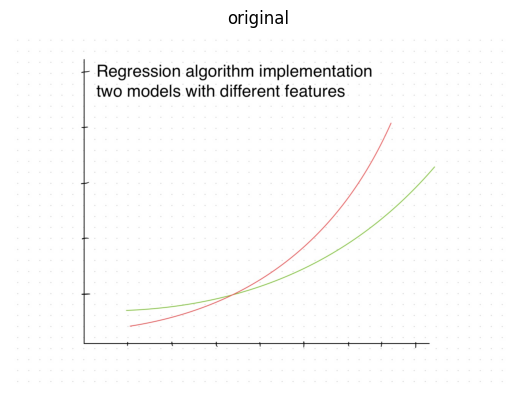

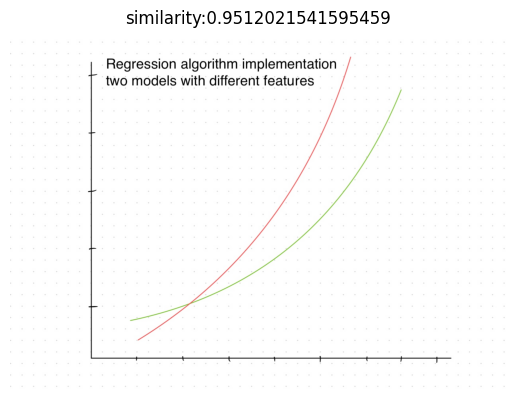

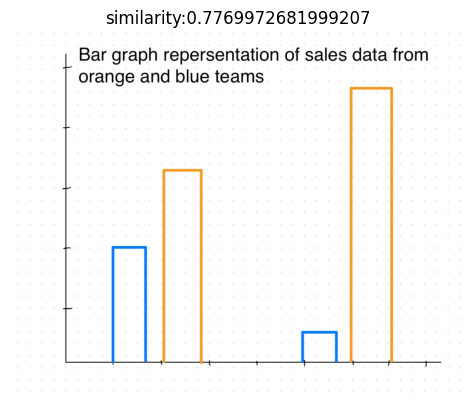

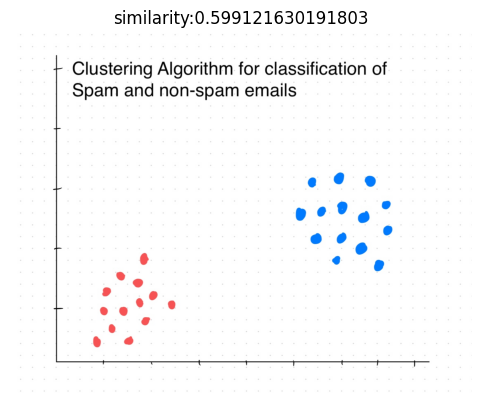

{'./Teacher/Teacher1.jpg': 0.9512021541595459, './Teacher/Teacher2.jpg': 0.7769972681999207, './Teacher/Teacher3.jpg': 0.599121630191803}


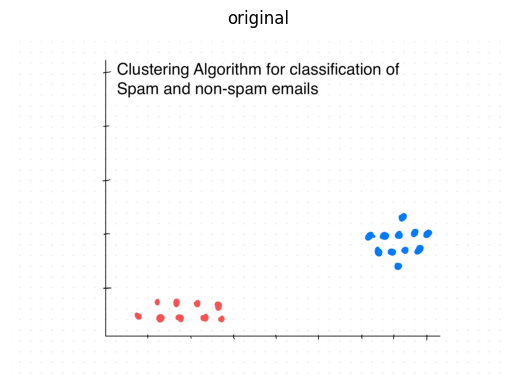

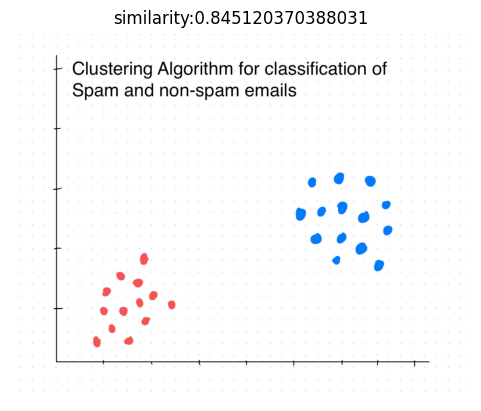

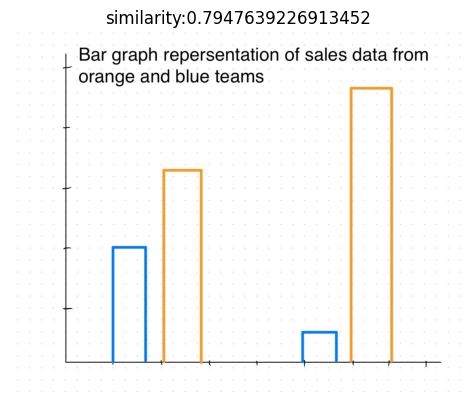

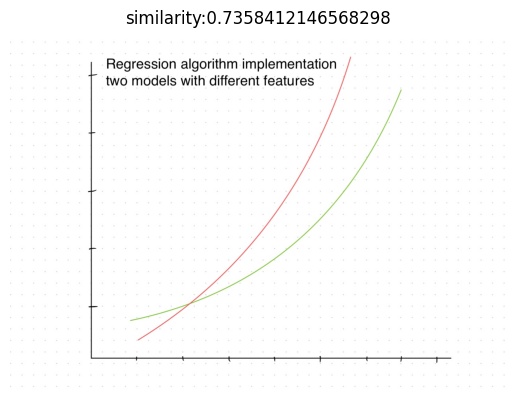

{'./Teacher/Teacher3.jpg': 0.845120370388031, './Teacher/Teacher2.jpg': 0.7947639226913452, './Teacher/Teacher1.jpg': 0.7358412146568298}


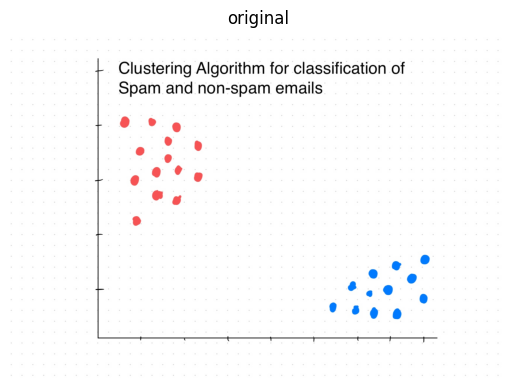

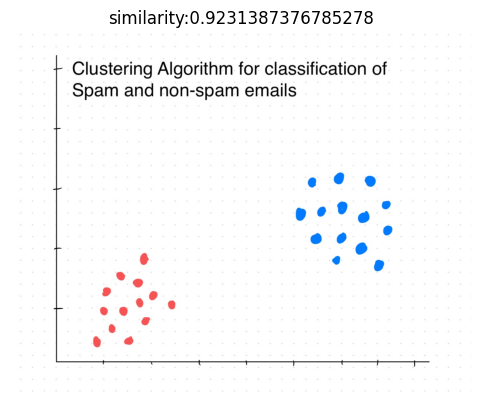

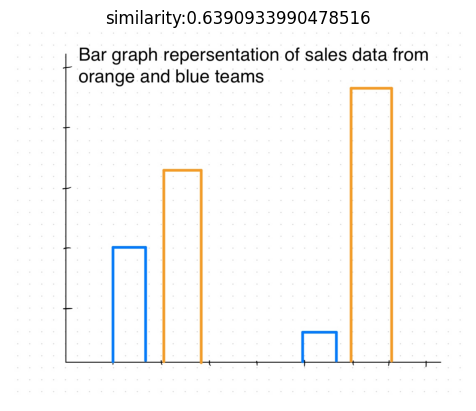

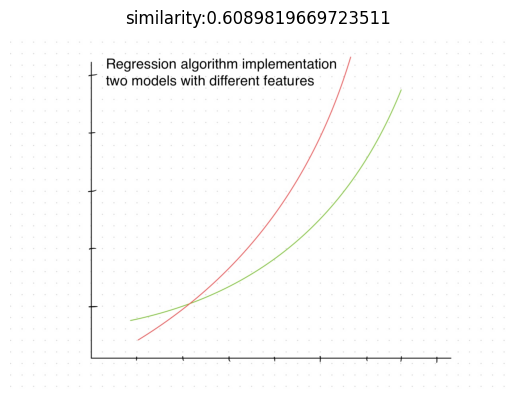

{'./Teacher/Teacher3.jpg': 0.9231387376785278, './Teacher/Teacher2.jpg': 0.6390933990478516, './Teacher/Teacher1.jpg': 0.6089819669723511}


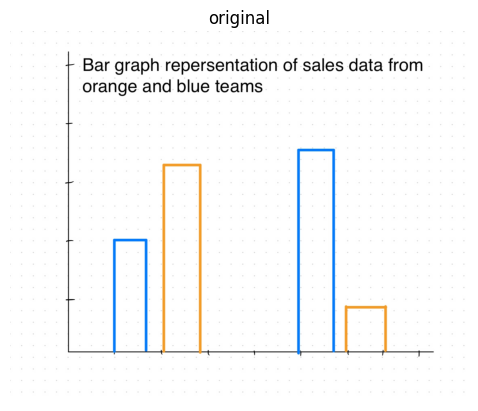

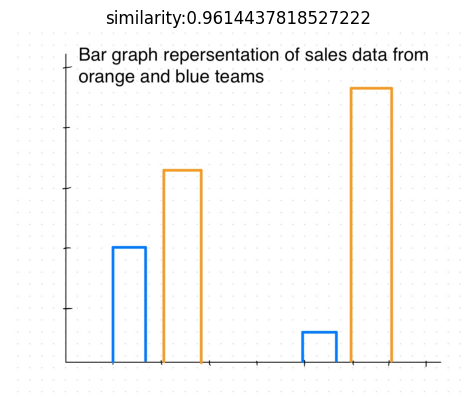

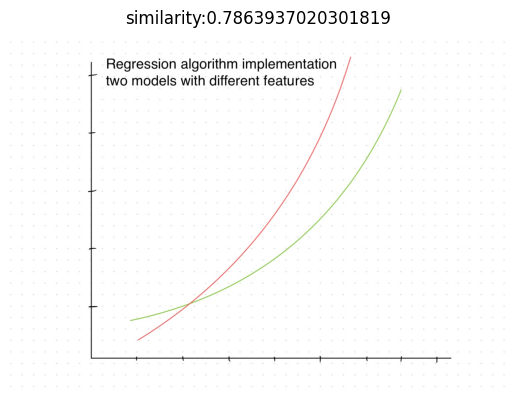

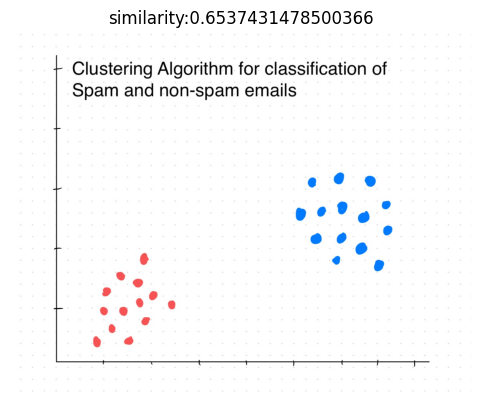

{'./Teacher/Teacher2.jpg': 0.9614437818527222, './Teacher/Teacher1.jpg': 0.7863937020301819, './Teacher/Teacher3.jpg': 0.6537431478500366}


In [ ]:

ImgSim.validate_student()

In [ ]:
ImgSim = Img2Vec('vgg19', weights='DEFAULT')

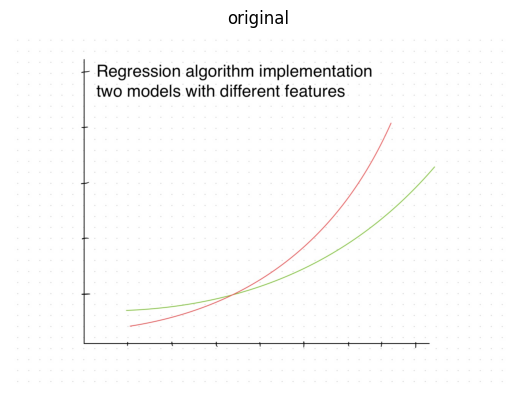

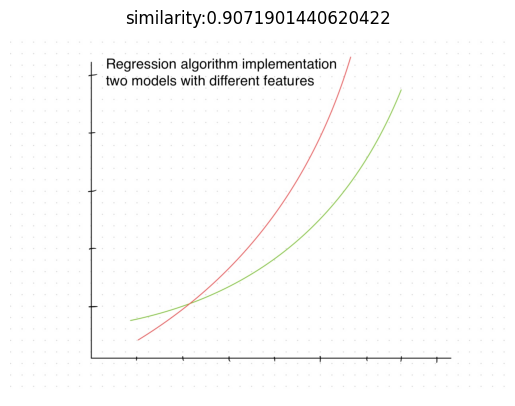

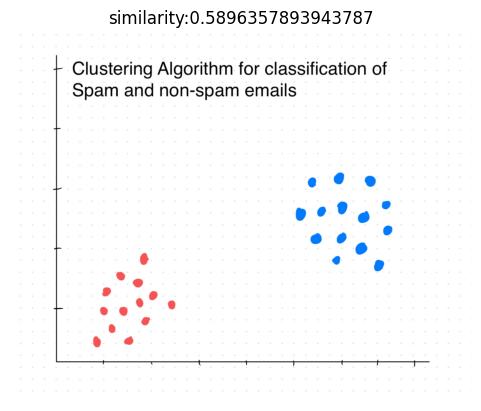

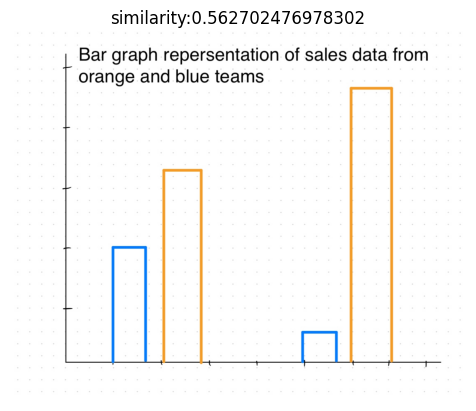

{'./Teacher/Teacher1.jpg': 0.9071901440620422, './Teacher/Teacher3.jpg': 0.5896357893943787, './Teacher/Teacher2.jpg': 0.562702476978302}


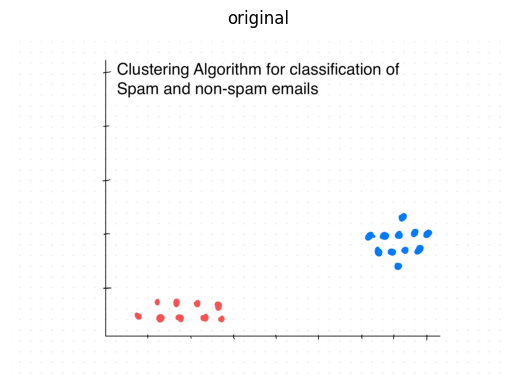

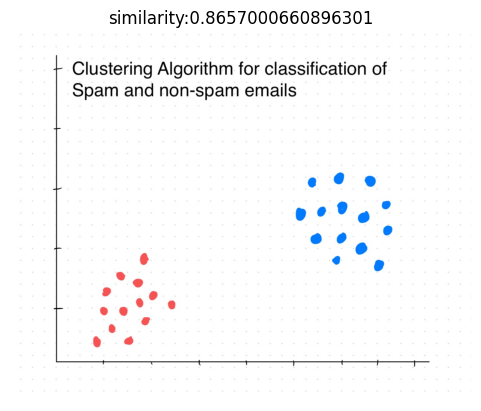

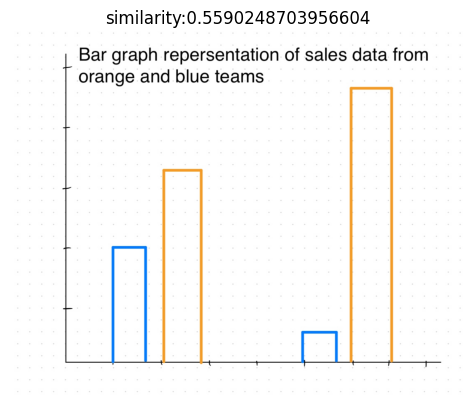

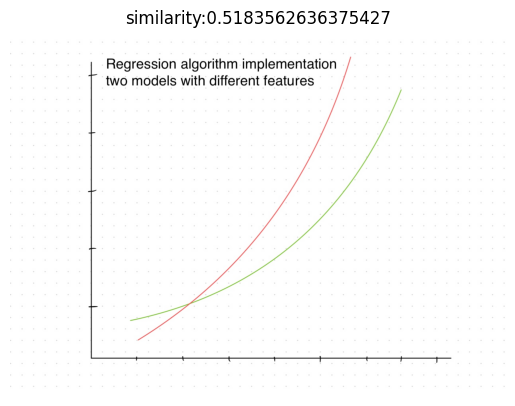

{'./Teacher/Teacher3.jpg': 0.8657000660896301, './Teacher/Teacher2.jpg': 0.5590248703956604, './Teacher/Teacher1.jpg': 0.5183562636375427}


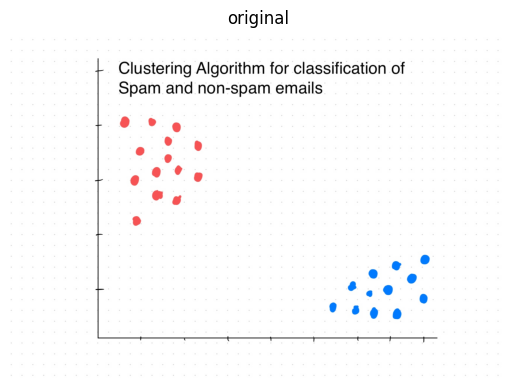

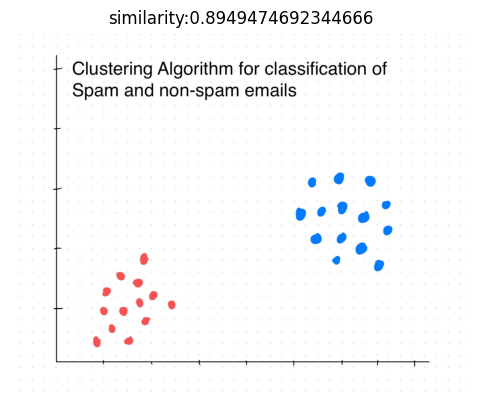

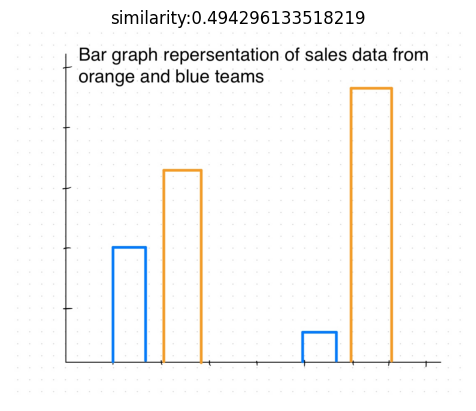

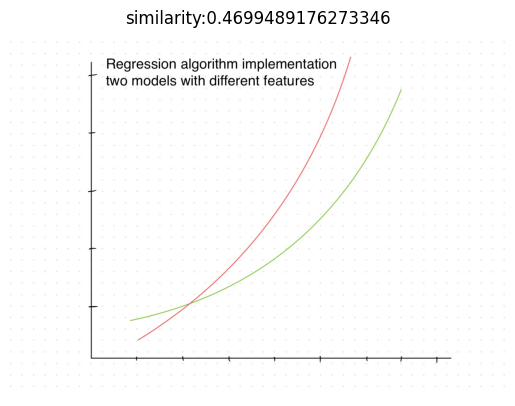

{'./Teacher/Teacher3.jpg': 0.8949474692344666, './Teacher/Teacher2.jpg': 0.494296133518219, './Teacher/Teacher1.jpg': 0.4699489176273346}


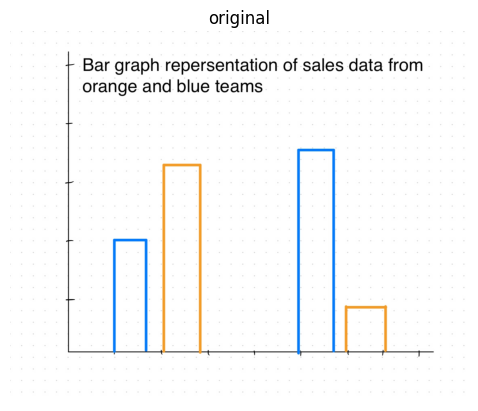

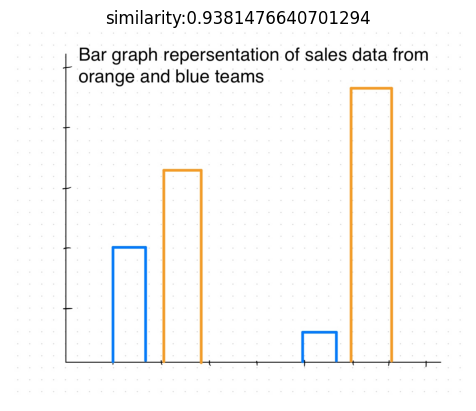

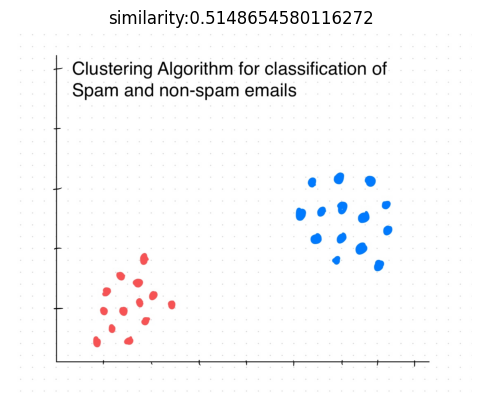

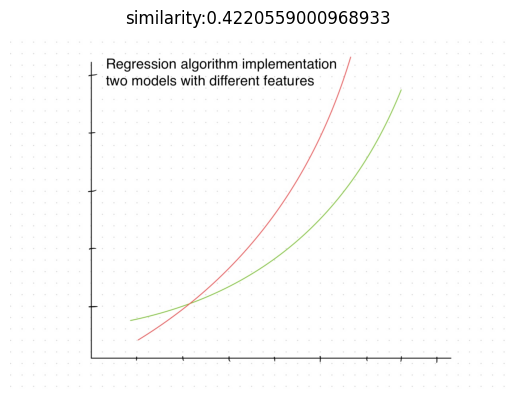

{'./Teacher/Teacher2.jpg': 0.9381476640701294, './Teacher/Teacher3.jpg': 0.5148654580116272, './Teacher/Teacher1.jpg': 0.4220559000968933}


In [ ]:

ImgSim.validate_student()

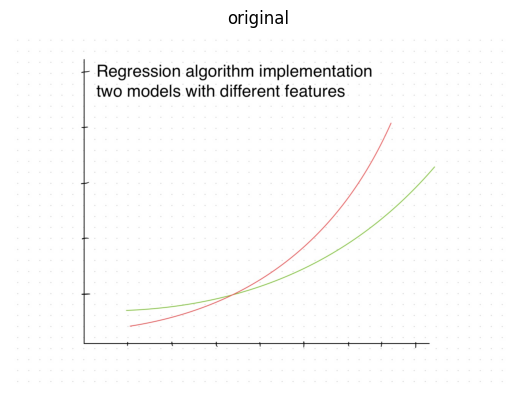

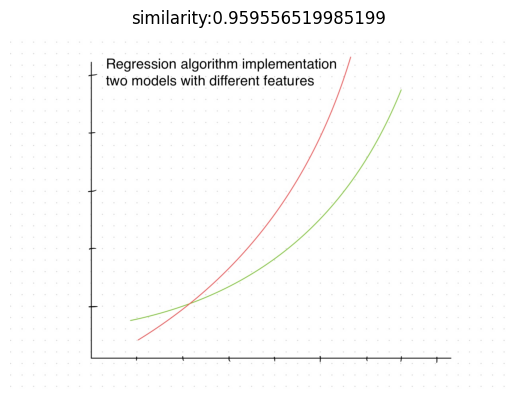

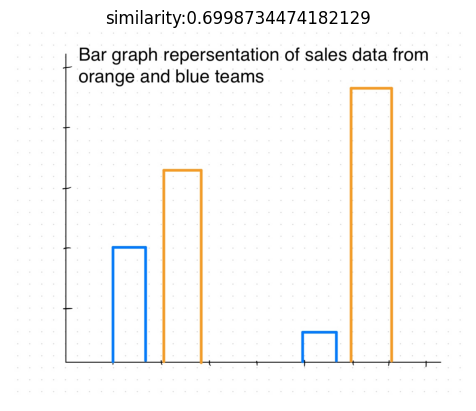

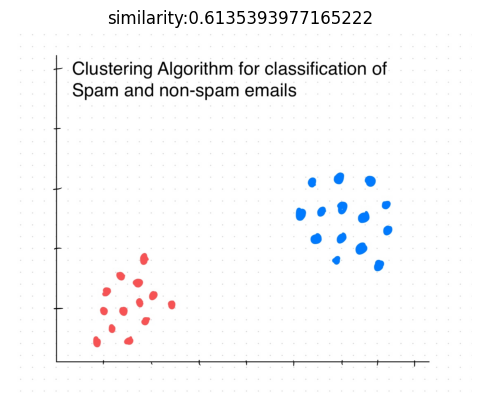

{'./Teacher/Teacher1.jpg': 0.959556519985199, './Teacher/Teacher2.jpg': 0.6998734474182129, './Teacher/Teacher3.jpg': 0.6135393977165222}


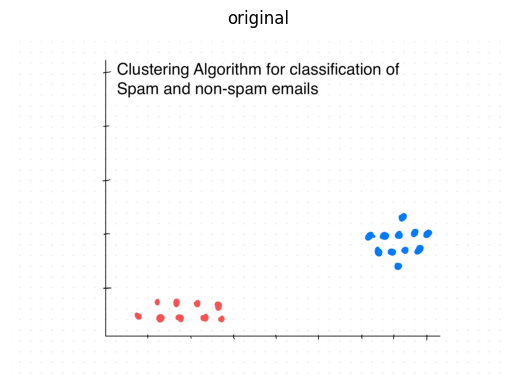

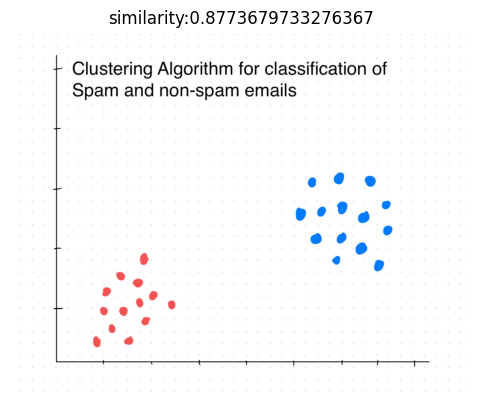

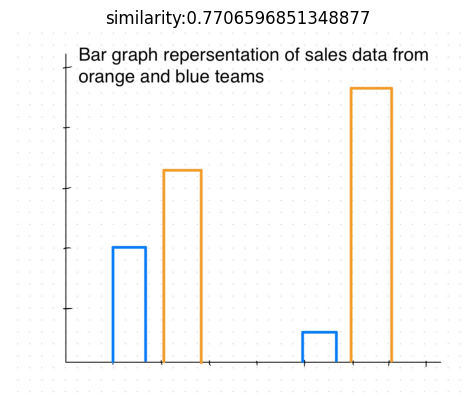

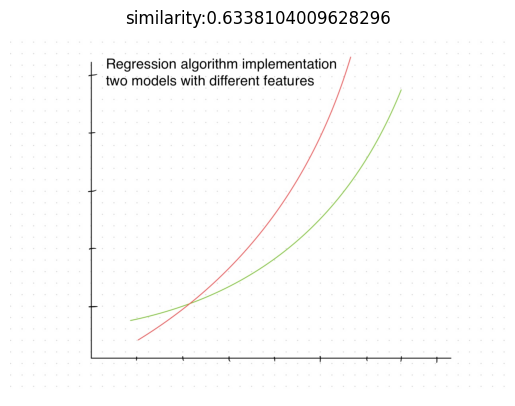

{'./Teacher/Teacher3.jpg': 0.8773679733276367, './Teacher/Teacher2.jpg': 0.7706596851348877, './Teacher/Teacher1.jpg': 0.6338104009628296}


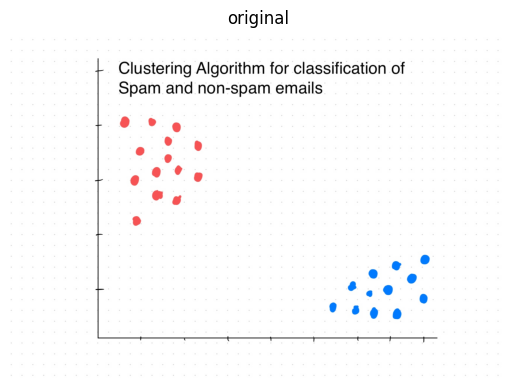

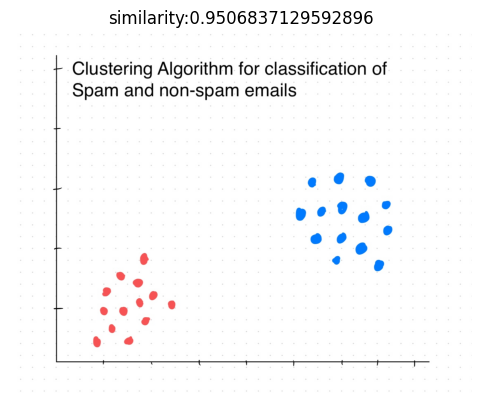

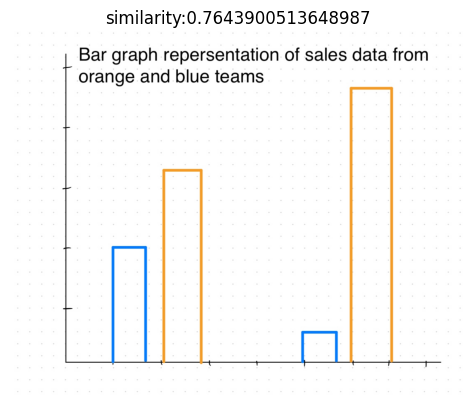

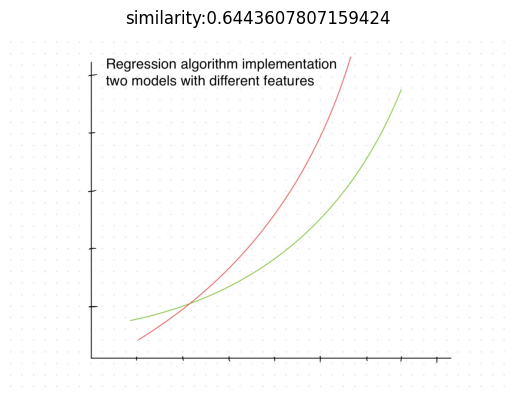

{'./Teacher/Teacher3.jpg': 0.9506837129592896, './Teacher/Teacher2.jpg': 0.7643900513648987, './Teacher/Teacher1.jpg': 0.6443607807159424}


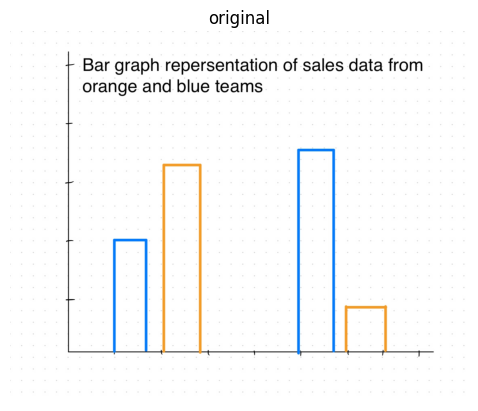

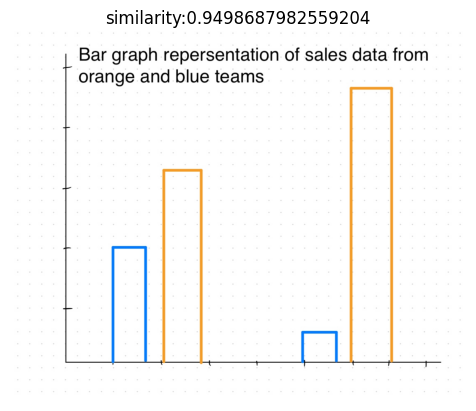

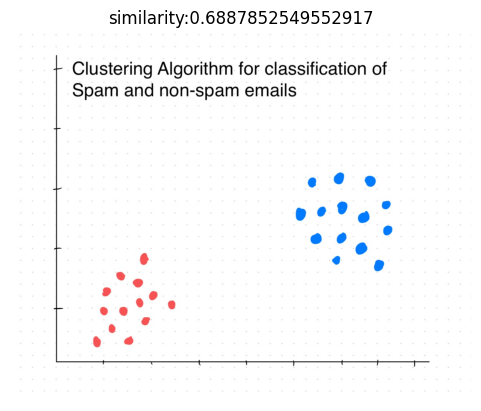

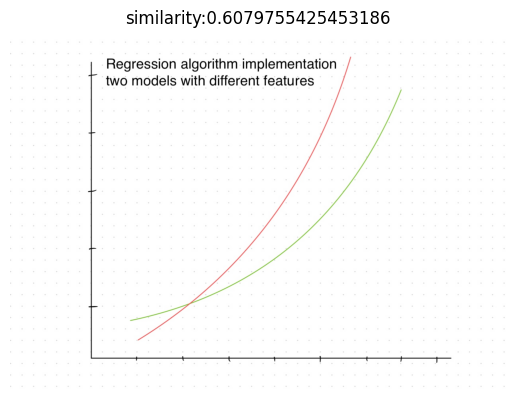

{'./Teacher/Teacher2.jpg': 0.9498687982559204, './Teacher/Teacher3.jpg': 0.6887852549552917, './Teacher/Teacher1.jpg': 0.6079755425453186}


In [ ]:
ImgSim = Img2Vec('efficientnet_b1', weights='EfficientNet_B1_Weights.IMAGENET1K_V1')
ImgSim.embed_dataset("./Teacher")
ImgSim.validate_student()

1/1 [==============================] - 0s 206ms/step


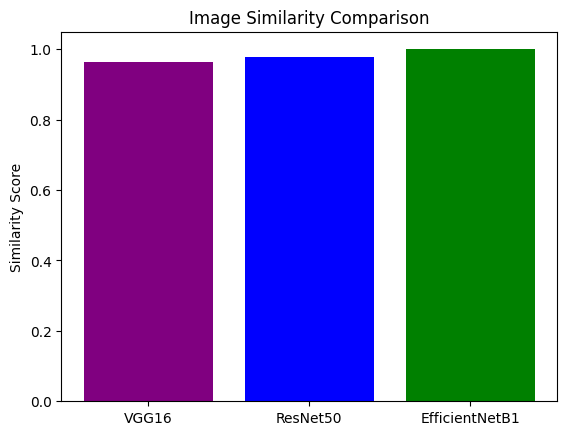

VGG16 Similarity Score: 0.9631316065788269
ResNet50 Similarity Score: 0.9770836234092712
EfficientNetB1 Similarity Score: 0.999973475933075


In [10]:
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import backend as K
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.applications.efficientnet import EfficientNetB1, preprocess_input as efficientnet_preprocess


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def get_feature_vector(model, img_path):
    img_array = preprocess_image(img_path)
    features = model.predict(img_array)
    return features.flatten()

def calculate_similarity(model, img_path1, img_path2):
    features1 = get_feature_vector(model, img_path1)
    features2 = get_feature_vector(model, img_path2)
    similarity = 1 - cosine(features1, features2)
    return similarity

img_path1 = './teacher.png'
img_path2 = './student.png'

vgg_similarity = calculate_similarity(VGG16(weights='imagenet', include_top=False), img_path1, img_path2)
resnet_similarity = calculate_similarity(ResNet50(weights='imagenet', include_top=False), img_path1, img_path2)
efficientnet_similarity = calculate_similarity(EfficientNetB1(weights='imagenet', include_top=False), img_path1, img_path2)

models = ['VGG16', 'ResNet50', 'EfficientNetB1']
similarities = [vgg_similarity, resnet_similarity, efficientnet_similarity]

plt.bar(models, similarities, color=['purple', 'blue', 'green', 'orange'])
plt.ylabel('Similarity Score')
plt.title('Image Similarity Comparison')
plt.show()

print(f'VGG16 Similarity Score: {vgg_similarity}')
print(f'ResNet50 Similarity Score: {resnet_similarity}')
print(f'EfficientNetB1 Similarity Score: {efficientnet_similarity}')


In [9]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from scipy.spatial.distance import cosine

def custom_cnn_model(input_shape, embedding_size):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(embedding_size, activation='linear'))

    return model


#Custom formating
input_shape_custom = (224, 224, 3)
embedding_size_custom = 128

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def get_feature_vector(img_path, custom_model):
    img_array = preprocess_image(img_path)
    features = custom_model.predict(img_array)
    return features.flatten()

def calculate_similarity(img_path1, img_path2, custom_model):
    features1 = get_feature_vector(img_path1, custom_model)
    features2 = get_feature_vector(img_path2, custom_model)
    similarity = 1 - cosine(features1, features2)
    return similarity

#custom model
custom_model = custom_cnn_model(input_shape_custom, embedding_size_custom)

img_path1 = './teacher.png'
img_path2 = './student.png'

similarity_score_custom = calculate_similarity(img_path1, img_path2, custom_model)
print(f'Custom Model Similarity Score: {similarity_score_custom}')


1/1 [==============================] - 0s 68ms/step
Custom Model Similarity Score: 0.871833860874176
